In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

while os.getcwd().split(os.sep)[-1] != "neurolib":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.aln import ALNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_aln
from neurolib.control.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

# This function reads out the final state of a simulation
def getfinalstate(model):
    N = model.params.Cmat.shape[0]
    V = len(model.state_vars)
    T = model.getMaxDelay() + 1
    state = np.zeros((N, V, T))
    for v in range(V):
        if "rates" in model.state_vars[v] or "IA" in model.state_vars[v]:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n, -T:]
        else:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n]
    return state


def setinitstate(model, state):
    N = model.params.Cmat.shape[0]
    V = len(model.init_vars)
    T = model.getMaxDelay() + 1

    for n in range(N):
        for v in range(V):
            if "rates" in model.init_vars[v] or "IA" in model.init_vars[v]:
                model.params[model.init_vars[v]] = state[:, v, -T:]
            else:
                model.params[model.init_vars[v]] = state[:, v, -1]

    return

def getstate(model):
    state = np.concatenate(  ( np.concatenate((model.params["rates_exc_init"][:, np.newaxis, -1],
                                            model.params["rates_inh_init"][:, np.newaxis, -1],
                                            model.params["IA_init"][:, np.newaxis, -1], ), axis=1, )[:, :, np.newaxis],
                            np.stack((model.rates_exc, model.rates_inh, model.IA), axis=1),),axis=2,  )
    
    return state

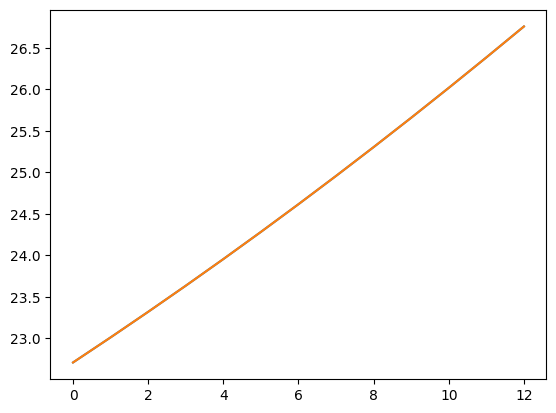

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.54729571e-12 -2.95585778e-12 -1.18407684e-09 -1.43471901e-08
 -3.66180615e-08 -6.58366162e-08 -1.00367167e-07 -1.39072853e-07
 -1.80943729e-07]


In [19]:
cmat = np.array( [[0., 0.0], [1., 0.]] )  # diagonal elements are zero, connection strength is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

model = ALNModel(Cmat=cmat, Dmat=dmat)
model.params.mue_ext_mean = 2.
model.params.mui_ext_mean = 0.5

model.params.de = 0.0
model.params.di = 0.0

model.params.a = 15.
model.params.b = 40.

model.params.IA_init = 20. * np.ones((model.params.N,1))
model.params.duration = 1.
model.run()
setinitstate(model, getfinalstate(model))


dt = model.params["dt"]
duration = 1.2
amplitude = 1.
period = duration /4.

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in x-channel in node 0

model.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
#input[0,1:-5] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.5, dt)/period) # other functions or random values can be used as well

fac = 1e-4
input[0,2] = 10.*fac
input[0,3] = -5.*fac

# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["ext_exc_current"] = input_nw[:,0,:]
model.params["ext_inh_current"] = input_nw[:,1,:]
model.run()

# Define the result of the stimulation as target
target = getstate(model)

# Remove stimuli and re-run the simulation
model.params["ext_exc_current"] = zero_input_nw[:,0,:]
model.params["ext_inh_current"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state = getstate(model)
#plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

plt.plot(state[1,2,:])
plt.plot(target[1,2,:])
plt.show()
print(state[1,2,:]-target[1,2,:])

Compute control for a deterministic system
Cost in iteration 0: 3.4019023077112967e-15
Cost in iteration 25: 2.9408557725449035e-18
Cost in iteration 50: 1.8551067991705365e-18
Cost in iteration 75: 1.4604551389604368e-18
Cost in iteration 100: 1.301695949014117e-18
Final cost : 1.301695949014117e-18


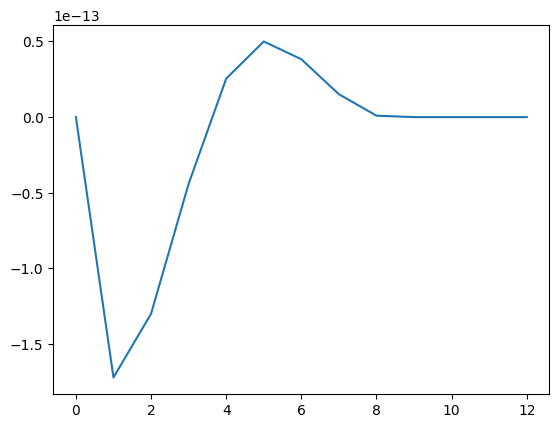

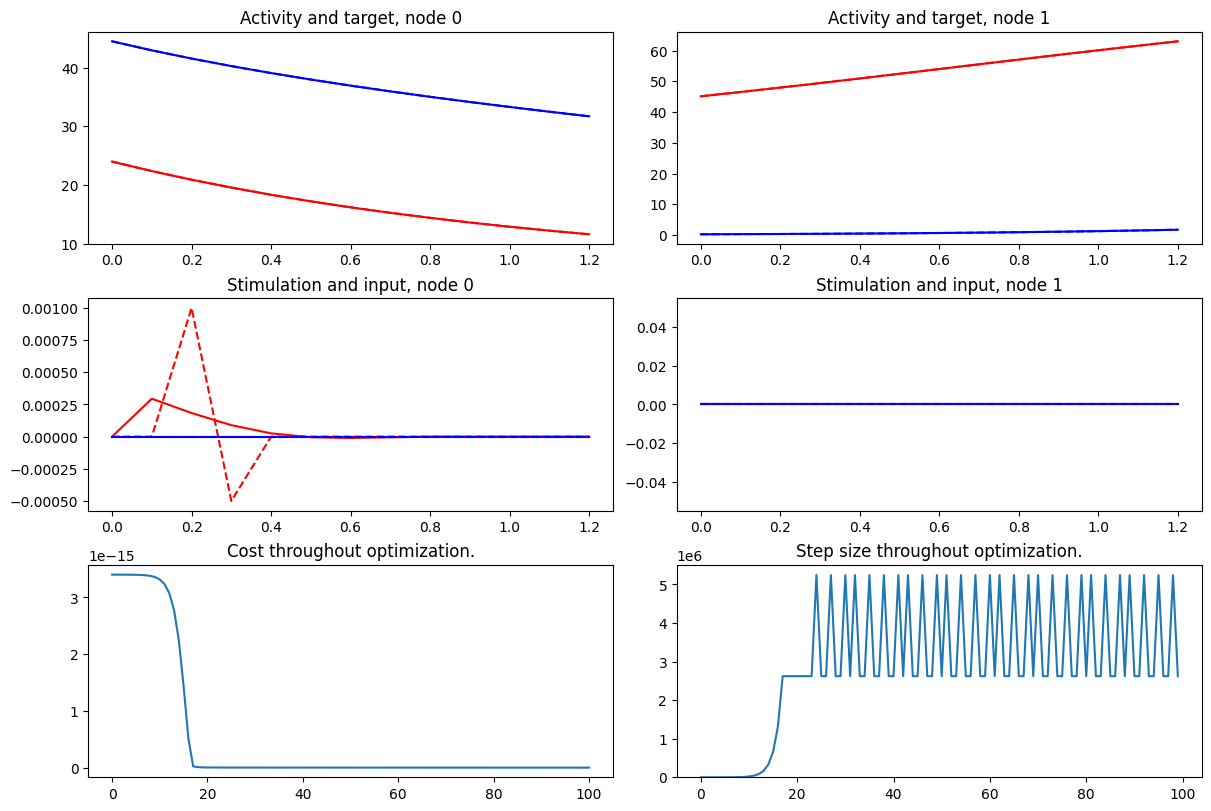

In [20]:
# we define the precision matrix to specify, in which nodes and channels we measure deviations from the target
cost_mat = np.zeros( (model.params.N, len(model.output_vars)) )
cost_mat[1,2] = 1. # only measure in y-channel in node 1

# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["ext_exc_current"] = zero_input_nw[:,0,:]
model.params["ext_inh_current"] = zero_input_nw[:,0,:]

# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_aln.OcAln(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(100)

plt.plot(model_controlled.gradient[0,0,:])
plt.show()

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 6.768968854079446e-20
Cost in iteration 100: 6.73848789095519e-20
Cost in iteration 200: 6.70836375820668e-20
Cost in iteration 300: 6.678585273131059e-20
Cost in iteration 400: 6.648885097267756e-20
Cost in iteration 500: 6.61948336364077e-20
Cost in iteration 600: 6.590534940539488e-20
Cost in iteration 700: 6.56150212042851e-20
Cost in iteration 800: 6.532843146675442e-20
Cost in iteration 900: 6.50442875760521e-20
Cost in iteration 1000: 6.476377250231176e-20
Cost in iteration 1100: 6.448276597327619e-20
Cost in iteration 1200: 6.420565732840452e-20
Cost in iteration 1300: 6.393259484577903e-20
Cost in iteration 1400: 6.365796835742546e-20
Cost in iteration 1500: 6.338705122179032e-20
Cost in iteration 1600: 6.312064082136987e-20
Cost in iteration 1700: 6.285239779861679e-20
Cost in iteration 1800: 6.258733168407425e-20
Cost in iteration 1900: 6.232497671722446e-20
Cost in iteration 2000: 6.206594255375633e-20
Cost in 

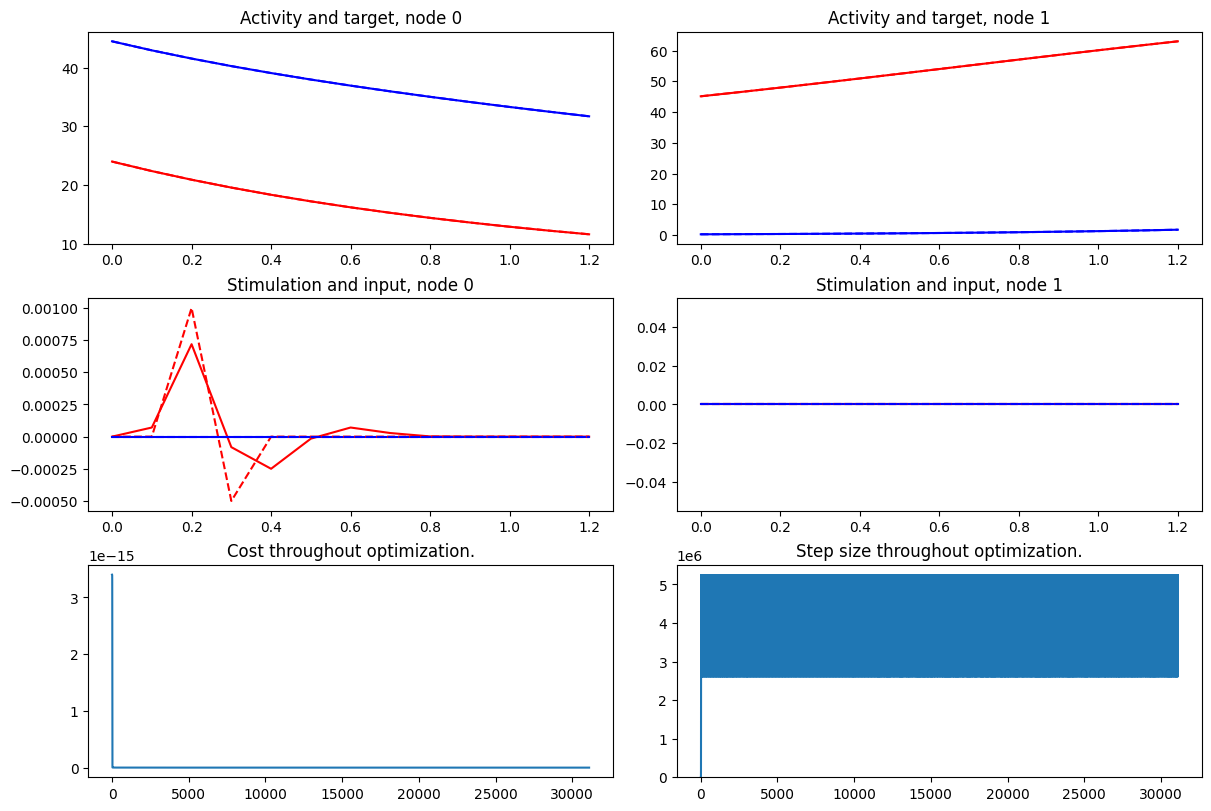

In [24]:
# Do another 1000 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.print_array = np.arange(0,10001,100)
#model_controlled.step = 1e16
#model_controlled.zero_step_encountered = False
model_controlled.optimize(10000)

state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

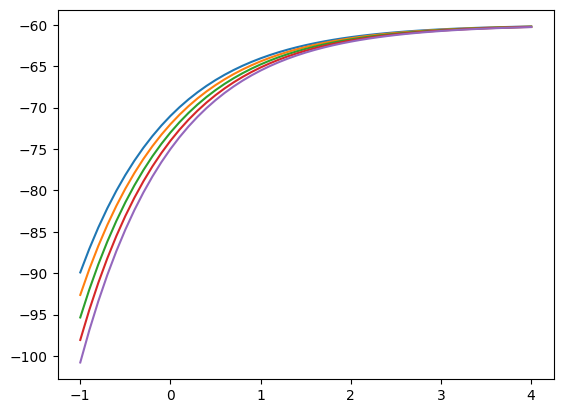

In [10]:
def Vfunc(s, m):
    return (-60 - (10.+s)*np.exp(-m))


mu = np.arange(-1, 4.1, 0.1)

for sig in [1., 2., 3., 4., 5.]:
    plt.plot(mu, Vfunc(sig, mu, ))

plt.show()